In [1]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import random
from PIL import Image

In [2]:
random.seed(8)

In [3]:
image_path = glob.glob("degus/*.jpg")
print("Found %i images..."%(len(image_path)))

Found 54 images...


In [4]:
labels_path = glob.glob("degus/*.txt")
print("Found %i labels..."%(len(labels_path)))

Found 54 labels...


In [5]:
imagesSum=len(image_path)
images=[]

for i in range(imagesSum):
    img = cv2.imread(image_path[i])
    images.append(img)
    
#len(images)    

In [6]:
labelsSum=len(labels_path)
labels=[]
for i in range(labelsSum):
    labels_path_2read =  open(labels_path[i],'r')
    label=labels_path_2read.readlines()
    labels.append(label)
    labels_path_2read.close()
    
#len(labels)

54

In [7]:
labels[0]

['0 0.315278 0.467573 0.458333 0.742678\n']

In [8]:
#loop for chaning bboxes place from lables txt
#its important while using albumentations format to augumentation
i = 0
labelsLen = len(labels)
bboxesALL = []
bboxesALL_labels = []
while(True):
    NextLabels = labels[i]
    SumNextLabels = len(NextLabels)
    for j in range(SumNextLabels):
        label = NextLabels
        labelj = label[j]
        splitLabelq = labelj.split()
        splitLabel = [float(j) for j in splitLabelq]
        category_id = splitLabel[0]
        x_center = splitLabel[1]
        y_center = splitLabel[2]
        width = splitLabel[3]
        height = splitLabel[4]
        bboxes = [[x_center, y_center, width, height,category_id]]
        bboxesALL.append(bboxes[0])
        if SumNextLabels == len(bboxesALL):
            bboxesALL_labels.append(bboxesALL.copy())
            bboxesALL.clear()
            i+=1
    if i == len(labels):
        break
        
#len(bboxesALL_labels)

In [9]:
HorizontalFlip_CLAHE = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.CLAHE(p=1)
], bbox_params=A.BboxParams(format='yolo'))

In [10]:
#using a lopp to transform images and lables location
transform=HorizontalFlip_CLAHE
i=0
transformed_image_list=[]
transformed_bboxes_list=[]
while i<=len(images) and len(bboxesALL_labels):
    try:
        #print(i)
        transformed = transform(image=images[i], bboxes=bboxesALL_labels[i])
        transformed_image = transformed['image']
        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
        transformed_image_list.append(transformed_image)
        transformed_bboxes = transformed['bboxes']
        transformed_bboxes_list.append(transformed_bboxes)
        i += 1
    except IndexError:
        break

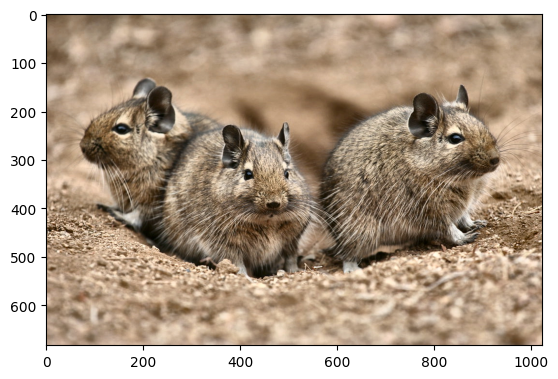

In [11]:
#transformed image
plt.imshow(transformed_image_list[1])

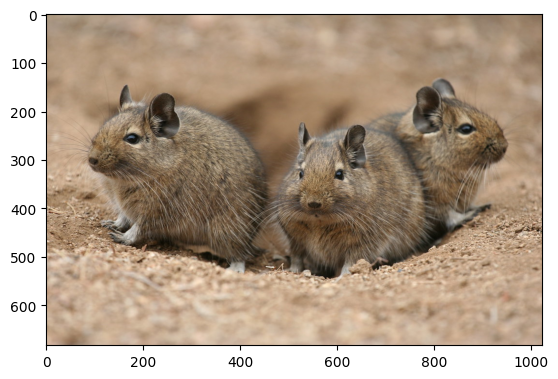

In [12]:
#basic image
plt.imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))

In [13]:
#transforming bbox data to be writable
transfrmedBboxesALL=[]
for j in range(len(transformed_bboxes_list)):
    transformedCords=len(transformed_bboxes_list[j])
    transfrmedBboxes=[]
    for i in range(transformedCords):
        dataTransformed=list((transformed_bboxes_list[j])[i])
        dataTransformed_list = np.array(dataTransformed, dtype=np.float32)
        dataTransformed_list=list(dataTransformed_list)
        transfrmedBboxes.append(dataTransformed_list)
        if transformedCords==len(transfrmedBboxes):
            transfrmedBboxesALL.append(transfrmedBboxes.copy())
            transfrmedBboxes.clear()

In [14]:
#changing the order of the coordinates to fit the yolo format agai
bboxes_to_txt=[]
for j in range(len(transfrmedBboxesALL)):
    cords=len(transfrmedBboxesALL[j])
    bboxes_cords=[]
    for i in range(cords):
        category_id=int(transfrmedBboxesALL[j][i][4])
        x_center=transfrmedBboxesALL[j][i][0]
        y_center=transfrmedBboxesALL[j][i][1]
        width=transfrmedBboxesALL[j][i][2]
        height=transfrmedBboxesALL[j][i][3]
        bboxes = [[category_id,x_center, y_center, width, height]]
        bboxes_cords.append(bboxes[0])
        if cords==len(bboxes_cords):
            bboxes_to_txt.append(bboxes_cords.copy())
            bboxes_cords.clear()

In [15]:
#removing the .txt name from the ending so that the labels, along with the photos, have a similar name
labels_paths_list=[]
for i in range(len(labels_path)):
    label1=labels_path[i].split('\\')
    label_1=label1[1]
    label_1=label_1.split('.txt')
    label_1=label_1[0]
    labels_paths_list.append(label_1)

In [16]:
#anaglogically for .jpg
image_path_list=[]
for i in range(len(image_path)):
    label1=image_path[i].split('\\')
    label_1=label1[1]
    label_1=label_1.split('.jpg')
    label_1=label_1[0]
    image_path_list.append(label_1)

In [17]:
#paths to save images and labels
path_images = 'IMG'
path_labels='IMG'
#transforName to make the file look new
TransformName='HorizontalFlip_CLAHE'

In [18]:
#Saving txt file with new name
for i, lst in enumerate(bboxes_to_txt):
    filename = "{}_{}_{}.txt".format(labels_paths_list[i],i,TransformName)
    filename = os.path.join(path_labels, filename)
    with open(filename, "w") as f:
        for item in lst:
            f.write(" ".join(map(str,item)) + '\n')

In [19]:
#saving jpg file with new name
for i, img in enumerate(transformed_image_list):
    img = Image.fromarray(np.uint8(img))
    filename_img = "{}_{}_{}.jpg".format(image_path_list[i],i,TransformName)
    filename_img = os.path.join(path_images, filename_img)
    img.save(filename_img)